In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1669665509784673473
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14444920832
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16965019731562479949
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
import os
import numpy as np
np.random.seed(777)

import keras
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

from keras.models import Model

from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.applications.mobilenet import MobileNet


from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from keras.utils import np_utils

from keras.regularizers import l2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_dir = '/content/drive/MyDrive/Tree Project_JN/Tree/Train'
test_dir = '/content/drive/MyDrive/Tree Project_JN/Tree/Test'


In [ ]:
import tensorflow as tf
print("TF Version:", tf.__version__)
import tensorflow_hub as hub
print("TF hub Version:", hub.__version__)
print("GPU", "availabe" if tf.config.list_physical_devices("GPU") else "not availabe")

TF Version: 2.8.2
TF hub Version: 0.12.0
GPU availabe


In [ ]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))
print("-"*100)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

/content/drive/MyDrive/Tree Project_JN/Tree/Train 0
/content/drive/MyDrive/Tree Project_JN/Tree/Train/Leaf Spots 160
/content/drive/MyDrive/Tree Project_JN/Tree/Train/Fresh Leaf 240
/content/drive/MyDrive/Tree Project_JN/Tree/Train/Stem Canker 240
/content/drive/MyDrive/Tree Project_JN/Tree/Train/Fresh Stem Canker 240
/content/drive/MyDrive/Tree Project_JN/Tree/Train/Leaf Necrosis 240
----------------------------------------------------------------------------------------------------
/content/drive/MyDrive/Tree Project_JN/Tree/Test 0
/content/drive/MyDrive/Tree Project_JN/Tree/Test/Leaf Necrosis 60
/content/drive/MyDrive/Tree Project_JN/Tree/Test/Leaf Spots 40
/content/drive/MyDrive/Tree Project_JN/Tree/Test/Stem Canker 60
/content/drive/MyDrive/Tree Project_JN/Tree/Test/Fresh Leaf 60
/content/drive/MyDrive/Tree Project_JN/Tree/Test/Fresh Stem Canker 60


In [ ]:
output_classes = 5
batch_size = 32
img_height, img_width = 224,224
input_shape = (img_height, img_width, 3)
epochs = 10
nb_train_samples =1120
nb_test_samples =280

In [ ]:
random_seed = np.random.seed(1142)
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = True,
    class_mode='categorical')


test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 1120 images belonging to 5 classes.
Found 280 images belonging to 5 classes.


In [ ]:
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)
from keras.models import Sequential
model = Sequential()

model.add(MobileNet(weights = "imagenet", include_top=False, pooling = 'avg'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer= adam_opt,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 1024)             3228864   
 nal)                                                            
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 3,233,989
Trainable params: 3,212,101
Non-trainable params: 21,888
_________________________________________________________________


In [ ]:
history = model.fit_generator(
  train_generator,
  steps_per_epoch = nb_train_samples // batch_size,
  epochs = epochs,
  validation_data = test_generator,
  validation_steps = nb_test_samples // batch_size)

Epoch 1/10
35/35 [==============================] - 729s 20s/step - loss: 2.0424 - accuracy: 0.3304 - val_loss: 1.8210 - val_accuracy: 0.4102
Epoch 2/10
35/35 [==============================] - 18s 508ms/step - loss: 1.4569 - accuracy: 0.4875 - val_loss: 1.8129 - val_accuracy: 0.4531
Epoch 3/10
35/35 [==============================] - 18s 510ms/step - loss: 1.0037 - accuracy: 0.6250 - val_loss: 1.6337 - val_accuracy: 0.4922
Epoch 4/10
35/35 [==============================] - 19s 546ms/step - loss: 0.7573 - accuracy: 0.7054 - val_loss: 1.3759 - val_accuracy: 0.5195
Epoch 5/10
35/35 [==============================] - 18s 512ms/step - loss: 0.5783 - accuracy: 0.7875 - val_loss: 1.0854 - val_accuracy: 0.5938
Epoch 6/10
35/35 [==============================] - 18s 511ms/step - loss: 0.4874 - accuracy: 0.8196 - val_loss: 0.8857 - val_accuracy: 0.6445
Epoch 7/10
35/35 [==============================] - 18s 515ms/step - loss: 0.4194 - accuracy: 0.8491 - val_loss: 0.6981 - val_accuracy: 0.7109


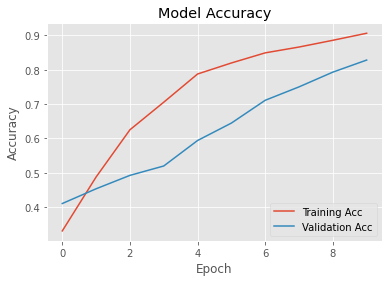

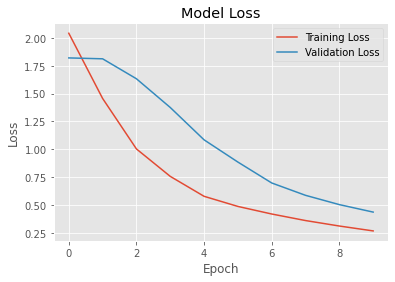

In [ ]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Validation Acc'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [ ]:
filename = test_generator.filenames
truth = test_generator.classes
label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

8/8 [==============================] - 4s 414ms/step
No of errors = 47/280


Confusion Matrix
[[60  0  0  0  0]
 [ 0 59  0  0  1]
 [18  0 38  2  2]
 [11  0  6 23  0]
 [ 0  7  0  0 53]]


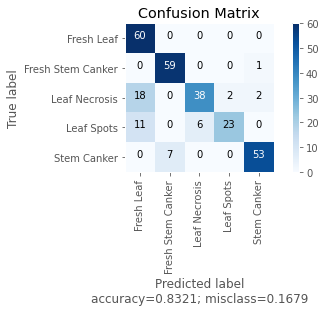

<Figure size 720x720 with 0 Axes>

In [ ]:
from sklearn import preprocessing
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 10})

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass)) 
    plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = test_generator.classes

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

       Fresh Leaf       0.67      1.00      0.81        60
Fresh Stem Canker       0.89      0.98      0.94        60
    Leaf Necrosis       0.86      0.63      0.73        60
       Leaf Spots       0.92      0.57      0.71        40
      Stem Canker       0.95      0.88      0.91        60

         accuracy                           0.83       280
        macro avg       0.86      0.81      0.82       280
     weighted avg       0.86      0.83      0.83       280



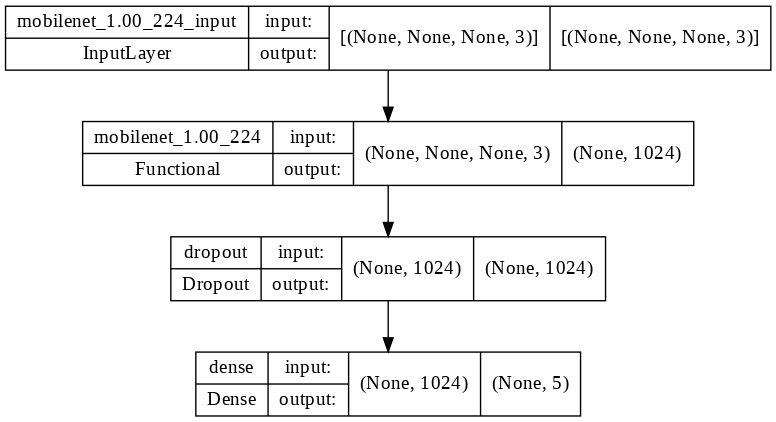

In [ ]:
import tensorflow.keras as keras
keras.utils.plot_model(model, show_shapes=True, dpi=100)